In [273]:

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az

rng = np.random.default_rng(1331)

In [274]:
pxi_df = pd.read_csv(r"data/pxi_results.csv")

pxi_df

,participant_id,game_name,trial,mode,difficulty,pxi_AA,pxi_CH,pxi_EC,pxi_GR,pxi_PF,pxi_AUT,pxi_CUR,pxi_IMM,pxi_MAS,pxi_MEA,pxi_ENJ,STIMES,TIMES
0,P001,WordZapper,1.0,2.0,0.0,Slightly agree,Agree,Slightly agree,Disagree,Disagree,Agree,Agree,Strongly Agree,Disagree,Neutral,Agree,1.744629e+12,1.744629e+12
1,P001,Turmoil,1.0,3.0,0.0,Agree,Agree,Agree,Slightly agree,slightly disagree,Agree,Agree,Strongly Agree,Agree,Neutral,Agree,1.744629e+12,1.744629e+12
2,P001,Boxing,1.0,0.0,2.0,Slightly agree,Agree,Strongly Agree,Strongly Agree,Strongly Agree,Slightly agree,Neutral,Strongly Agree,Agree,Neutral,Agree,1.744629e+12,1.744629e+12
3,P001,WordZapper,2.0,1.0,3.0,Slightly agree,Agree,Slightly agree,Disagree,slightly disagree,slightly disagree,Slightly agree,Strongly Agree,Disagree,Neutral,Neutral,1.744629e+12,1.744630e+12
4,P001,Turmoil,2.0,0.0,0.0,Slightly agree,Agree,Agree,Slightly agree,Slightly agree,Agree,Agree,Strongly Agree,Agree,Neutral,Slightly agree,1.744630e+12,1.744630e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,P011,Turmoil,2.0,2.0,0.0,Slightly agree,Agree,Agree,Strongly Agree,Strongly Agree,slightly disagree,Agree,Strongly Agree,Agree,Agree,Strongly Agree,1.746111e+12,1.746111e+12
90,P011,WordZapper,2.0,0.0,3.0,Slightly agree,Disagree,Strongly disagree,Strongly disagree,slightly disagree,slightly disagree,slightly disagree,Agree,Disagree,Slightly agree,slightly disagree,1.746111e+12,1.746111e+12
91,P011,Turmoil,3.0,0.0,0.0,Slightly agree,slightly disagree,Strongly Agree,Strongly Agree,Agree,Slightly agree,Agree,Strongly Agree,Slightly agree,Agree,Agree,1.746111e+12,1.746111e+12
92,P011,WordZapper,3.0,2.0,1.0,slightly disagree,Disagree,Disagree,Disagree,Disagree,Disagree,slightly disagree,Strongly Agree,Strongly disagree,Agree,slightly disagree,1.746111e+12,1.746111e+12


# Boxing

In [275]:
pxi_df_box = pxi_df[pxi_df["game_name"] == "Boxing"].drop(columns="game_name")
pxi_df_box.head()

,participant_id,trial,mode,difficulty,pxi_AA,pxi_CH,pxi_EC,pxi_GR,pxi_PF,pxi_AUT,pxi_CUR,pxi_IMM,pxi_MAS,pxi_MEA,pxi_ENJ,STIMES,TIMES
2,P001,1.0,0.0,2.0,Slightly agree,Agree,Strongly Agree,Strongly Agree,Strongly Agree,Slightly agree,Neutral,Strongly Agree,Agree,Neutral,Agree,1.744629e+12,1.744629e+12
5,P001,2.0,0.0,3.0,Agree,Agree,Strongly Agree,Agree,Agree,Agree,Agree,Strongly Agree,Agree,Neutral,Agree,1.744630e+12,1.744630e+12
6,P002,1.0,0.0,2.0,Agree,Strongly disagree,Strongly Agree,Strongly Agree,Strongly Agree,Slightly agree,Slightly agree,Strongly Agree,Strongly Agree,Neutral,Agree,1.745489e+12,1.745490e+12
9,P002,2.0,0.0,3.0,Agree,Strongly disagree,Strongly Agree,Strongly Agree,Strongly Agree,Agree,Agree,Strongly Agree,Agree,Slightly agree,Agree,1.745490e+12,1.745490e+12
14,P002,3.0,0.0,1.0,Agree,Neutral,Strongly Agree,Strongly Agree,Strongly Agree,Agree,Agree,Strongly Agree,Agree,Agree,Strongly Agree,1.745491e+12,1.745491e+12


In [276]:
diff_id, unique_diff = pd.factorize(pxi_df_box["difficulty"])
trial_id, unique_trial = pd.factorize(pxi_df_box["trial"])

In [277]:
pxi_id_to_number = {
    "strongly disagree": 0,
    "disagree": 1,
    "slightly disagree":2,
    "neutral": 3,
    "slightly agree": 4,
    "agree": 5,
    "strongly agree": 6
}

y_ch = pxi_df_box["pxi_CH"].str.lower().replace(pxi_id_to_number)
y_mas = pxi_df_box["pxi_MAS"].str.lower().replace(pxi_id_to_number)
y_imm = pxi_df_box["pxi_IMM"].str.lower().replace(pxi_id_to_number)


/tmp/ipykernel_13606/1351087819.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_ch = pxi_df_box["pxi_CH"].str.lower().replace(pxi_id_to_number)
/tmp/ipykernel_13606/1351087819.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_mas = pxi_df_box["pxi_MAS"].str.lower().replace(pxi_id_to_number)
/tmp/ipykernel_13606/1351087819.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in

## Challenge

### H1: A game's difficulty configuration or trial have an effect on on a player's perception of challenge

In [278]:
with pm.Model(coords={"difficulties": unique_diff, "trials": unique_trial}) as m_boxh1:
    current_difficulty = pm.Data("difficulty", diff_id)
    current_trial = pm.Data("trials", trial_id)
    
    alpha = pm.Normal("alpha", 0, 0.5, dims="difficulties")
    beta = pm.Normal("beta", 0, 0.5, dims="trials")
    sigma = pm.Exponential("sigma", 0.25)
    
    eta = pm.Deterministic("eta", alpha[current_difficulty] + beta[current_trial])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=y_ch.values)
    
    boxh1_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng)
    
    

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, cutpoints]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 12 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

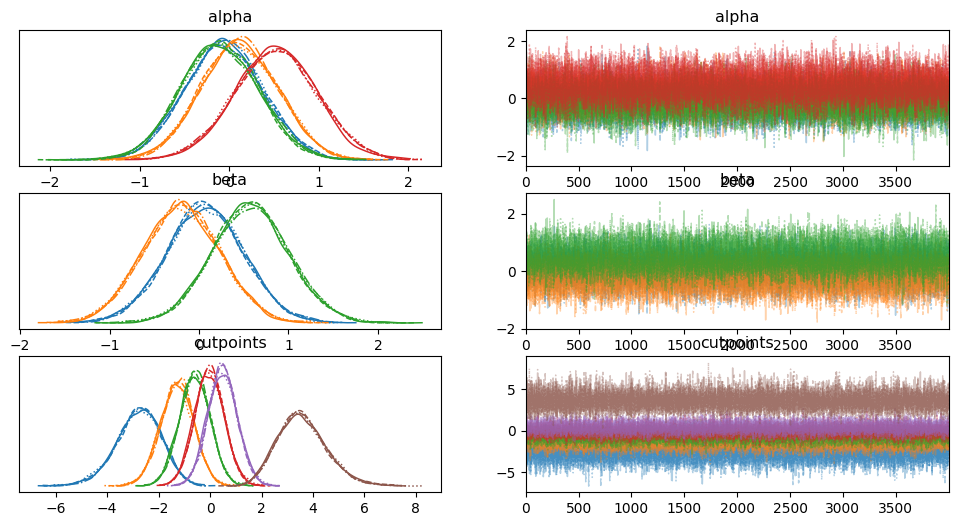

In [279]:
az.plot_trace(boxh1_trace, var_names=["alpha", "beta", "cutpoints"])

In [280]:
alpha_summary = az.summary(boxh1_trace, var_names="alpha")
alpha_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[2.0],-0.065,0.437,-0.886,0.748,0.003,0.004,16662.0,11742.0,1.0
alpha[3.0],0.114,0.430,-0.681,0.920,0.003,0.003,17569.0,12641.0,1.0
alpha[1.0],-0.109,0.434,-0.921,0.692,0.003,0.003,16894.0,11916.0,1.0
alpha[0.0],0.519,0.459,-0.355,1.377,0.003,0.003,18860.0,11763.0,1.0


In [281]:
beta_summary = az.summary(boxh1_trace, var_names="beta")
beta_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[1.0],0.070,0.433,-0.763,0.866,0.003,0.003,17744.0,12014.0,1.0
beta[2.0],-0.197,0.430,-0.985,0.632,0.003,0.003,17943.0,13178.0,1.0
beta[3.0],0.577,0.431,-0.226,1.399,0.003,0.003,17224.0,11867.0,1.0


#### interaction model

In [284]:
with pm.Model(coords={"trials": unique_trial, "difficulties": unique_diff}) as m_box_mh2_int:
    current_trial = pm.Data("trial", trial_id)
    current_difficulty = pm.Data("difficulty", diff_id)
    
    beta = pm.Normal("beta", 0, 0.5, dims="trials")
    alpha = pm.Normal("alpha", 0, 0.5, dims="difficulties")
    gamma = pm.Normal("gamma", 0, 0.5, dims=("difficulties", "trials"))
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha[current_difficulty] + beta[current_trial] + gamma[current_difficulty, current_trial])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedProbit("y", eta=eta, cutpoints=cutpoints, observed=y_ch.values)
    
    boxh2_int_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, gamma, sigma, cutpoints]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 20 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

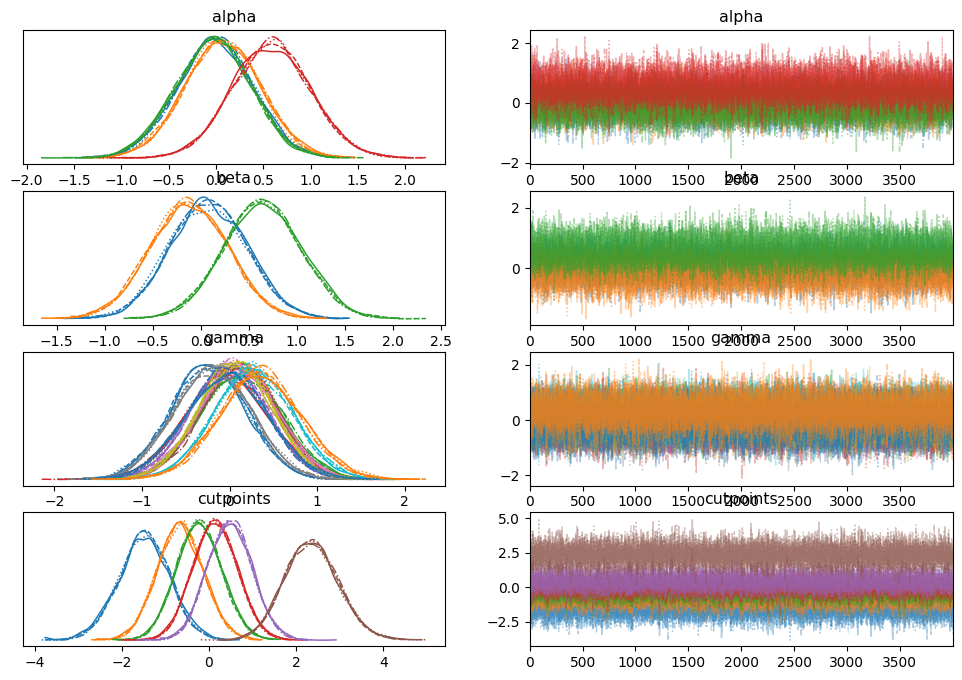

In [287]:
az.plot_trace(boxh2_int_trace, var_names=["alpha", "beta", "gamma", "cutpoints"])

In [285]:
alpha_summary_h3 = az.summary(boxh2_int_trace, var_names="alpha")
alpha_summary_h3

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[2.0],-0.011,0.397,-0.752,0.726,0.003,0.003,21436.0,13398.0,1.0
alpha[3.0],0.070,0.399,-0.678,0.821,0.003,0.003,22174.0,12505.0,1.0
alpha[1.0],-0.029,0.399,-0.794,0.698,0.003,0.003,19798.0,11873.0,1.0
alpha[0.0],0.583,0.414,-0.194,1.353,0.003,0.002,23659.0,12913.0,1.0


In [286]:
beta_summary_h3 = az.summary(boxh2_int_trace, var_names="beta")
beta_summary_h3

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[1.0],0.081,0.402,-0.654,0.839,0.003,0.003,19771.0,12009.0,1.0
beta[2.0],-0.122,0.403,-0.868,0.642,0.003,0.003,20853.0,13403.0,1.0
beta[3.0],0.645,0.403,-0.123,1.381,0.003,0.002,20930.0,12417.0,1.0


In [288]:
gamma_summary_h3 = az.summary(boxh2_int_trace, var_names="gamma")
gamma_summary_h3

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"gamma[2.0, 1.0]",-0.241,0.425,-1.067,0.526,0.003,0.003,25773.0,13289.0,1.0
"gamma[2.0, 2.0]",0.106,0.430,-0.752,0.867,0.003,0.003,27611.0,12729.0,1.0
"gamma[2.0, 3.0]",0.123,0.459,-0.715,1.014,0.003,0.004,32233.0,11358.0,1.0
"gamma[3.0, 1.0]",-0.040,0.463,-0.928,0.801,0.003,0.004,31312.0,11339.0,1.0
"gamma[3.0, 2.0]",-0.010,0.426,-0.827,0.775,0.003,0.003,24119.0,12777.0,1.0
"gamma[3.0, 3.0]",0.112,0.427,-0.701,0.906,0.003,0.003,24079.0,12279.0,1.0
"gamma[1.0, 1.0]",0.090,0.437,-0.736,0.905,0.003,0.003,28207.0,12684.0,1.0
"gamma[1.0, 2.0]",-0.196,0.439,-1.015,0.623,0.003,0.003,27379.0,12170.0,1.0
"gamma[1.0, 3.0]",0.069,0.422,-0.755,0.828,0.003,0.004,25927.0,12488.0,1.0
"gamma[0.0, 1.0]",0.269,0.446,-0.572,1.105,0.003,0.003,27744.0,11928.0,1.0


# Turmoil

In [290]:
pxi_df_turm = pxi_df[pxi_df["game_name"] == "Turmoil"].drop(columns="game_name")
pxi_df_turm.head()

,participant_id,trial,mode,difficulty,pxi_AA,pxi_CH,pxi_EC,pxi_GR,pxi_PF,pxi_AUT,pxi_CUR,pxi_IMM,pxi_MAS,pxi_MEA,pxi_ENJ,STIMES,TIMES
1,P001,1.0,3.0,0.0,Agree,Agree,Agree,Slightly agree,slightly disagree,Agree,Agree,Strongly Agree,Agree,Neutral,Agree,1.744629e+12,1.744629e+12
4,P001,2.0,0.0,0.0,Slightly agree,Agree,Agree,Slightly agree,Slightly agree,Agree,Agree,Strongly Agree,Agree,Neutral,Slightly agree,1.744630e+12,1.744630e+12
8,P002,1.0,2.0,0.0,Agree,Agree,Agree,Agree,Agree,Agree,Agree,Strongly Agree,Agree,Slightly agree,Strongly Agree,1.745490e+12,1.745490e+12
10,P002,2.0,0.0,0.0,Agree,Slightly agree,Strongly Agree,Strongly Agree,Strongly Agree,Agree,Slightly agree,Strongly Agree,Strongly Agree,Slightly agree,Agree,1.745490e+12,1.745490e+12
12,P002,3.0,1.0,0.0,Agree,Neutral,Agree,Strongly Agree,Strongly Agree,Slightly agree,Slightly agree,Strongly Agree,Strongly Agree,Slightly agree,Agree,1.745491e+12,1.745491e+12


In [291]:
diff_id, unique_diff = pd.factorize(pxi_df_turm["mode"])
trial_id, unique_trial = pd.factorize(pxi_df_turm["trial"])

In [292]:
y_ch = pxi_df_turm["pxi_CH"].str.lower().replace(pxi_id_to_number)
y_mas = pxi_df_turm["pxi_MAS"].str.lower().replace(pxi_id_to_number)
y_imm = pxi_df_turm["pxi_IMM"].str.lower().replace(pxi_id_to_number)


/tmp/ipykernel_13606/4288176752.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_ch = pxi_df_turm["pxi_CH"].str.lower().replace(pxi_id_to_number)
/tmp/ipykernel_13606/4288176752.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_mas = pxi_df_turm["pxi_MAS"].str.lower().replace(pxi_id_to_number)
/tmp/ipykernel_13606/4288176752.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in 

## Challenge

In [293]:
y_ch.unique()

array([5, 4, 3, 2, 1, 6])

### H1: A game's difficulty configuration or current trial have an effect on on a player's perception of challenge

In [294]:
with pm.Model(coords={"difficulties": unique_diff, "trials": unique_trial}) as m_turmh1:
    current_difficulty = pm.Data("difficulty", diff_id)
    current_trial = pm.Data("trial", trial_id)
    
    alpha = pm.Normal("alpha", 0, 0.5, dims="difficulties")
    beta = pm.Normal("beta", 0, 0.5, dims="trials")
    sigma = pm.Exponential("sigma", 0.25)
    
    eta = pm.Deterministic("eta", alpha[current_difficulty] + beta[current_trial])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,5,5), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=y_ch.values - 1)
    
    turmh1_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng)
    
    

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, cutpoints]


Output()

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/pytensor/compile/function/types.py:992: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 12 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

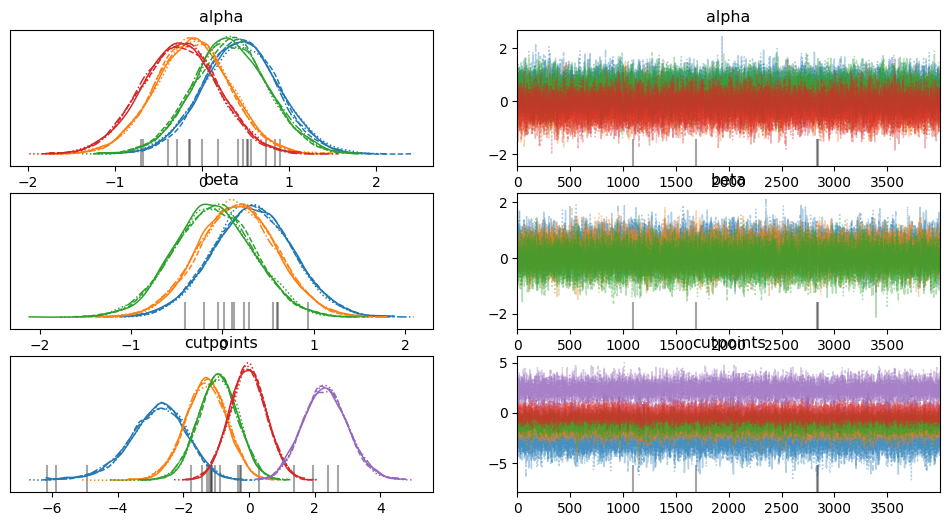

In [295]:
az.plot_trace(turmh1_trace, var_names=["alpha", "beta", "cutpoints"])

In [296]:
alpha_summary = az.summary(turmh1_trace, var_names="alpha")
alpha_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[3.0],0.439,0.435,-0.352,1.291,0.003,0.003,16028.0,10208.0,1.0
alpha[0.0],-0.108,0.428,-0.908,0.707,0.003,0.003,15598.0,10937.0,1.0
alpha[2.0],0.324,0.431,-0.483,1.144,0.003,0.003,16386.0,11288.0,1.0
alpha[1.0],-0.256,0.440,-1.094,0.555,0.003,0.003,16795.0,11791.0,1.0


In [297]:
beta_summary = az.summary(turmh1_trace, var_names="beta")
beta_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[1.0],0.334,0.435,-0.513,1.132,0.003,0.003,17114.0,10582.0,1.0
beta[2.0],0.163,0.426,-0.653,0.950,0.003,0.003,16513.0,11890.0,1.0
beta[3.0],-0.097,0.433,-0.908,0.714,0.004,0.003,14776.0,11249.0,1.0


#### interaction model

In [298]:
with pm.Model(coords={"trials": unique_trial, "difficulties": unique_diff}) as m_turmh2_int:
    current_trial = pm.Data("trial", trial_id)
    current_difficulty = pm.Data("difficulty", diff_id)
    
    beta = pm.Normal("beta", 0, 0.5, dims="trials")
    alpha = pm.Normal("alpha", 0, 0.5, dims="difficulties")
    gamma = pm.Normal("gamma", 0, 0.5, dims=("difficulties", "trials"))
    sigma = pm.Exponential("sigma", 0.25)
    
    eta = pm.Deterministic("eta", alpha[current_difficulty] + beta[current_trial] + gamma[current_difficulty, current_trial])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,5,5), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedProbit("y", eta=eta, cutpoints=cutpoints, observed=y_ch.values - 1)
    
    turmh2_int_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, gamma, sigma, cutpoints]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 20 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

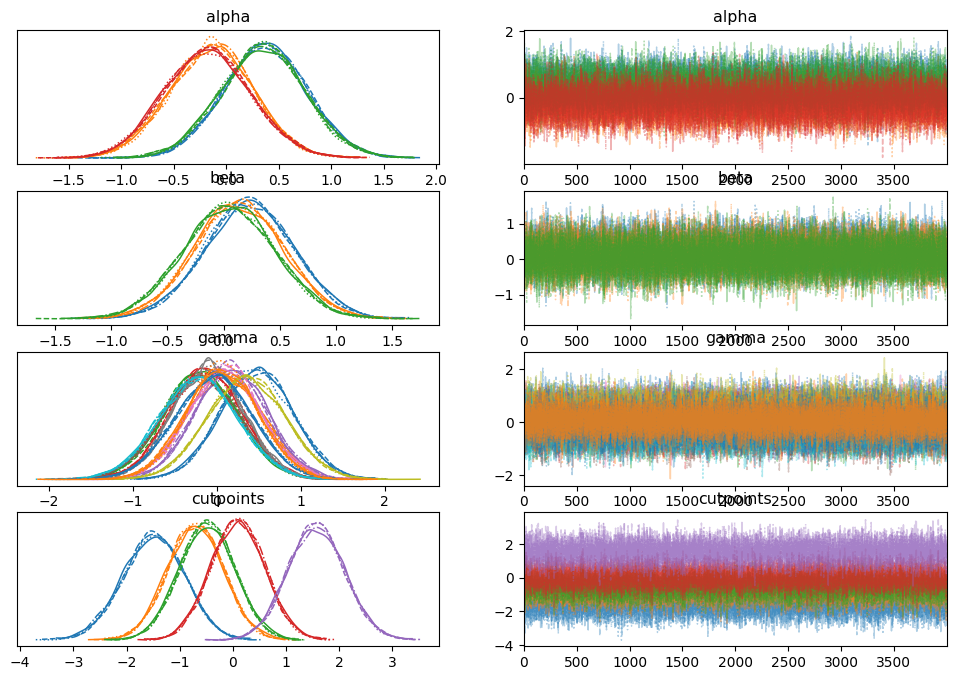

In [299]:
az.plot_trace(turmh2_int_trace, var_names=["alpha", "beta", "gamma", "cutpoints"])

In [300]:
alpha_summary_h3 = az.summary(turmh2_int_trace, var_names="alpha")
alpha_summary_h3

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[3.0],0.373,0.396,-0.345,1.146,0.003,0.002,20698.0,11677.0,1.0
alpha[0.0],-0.136,0.398,-0.887,0.608,0.003,0.003,21922.0,11737.0,1.0
alpha[2.0],0.349,0.402,-0.435,1.078,0.003,0.003,21939.0,12298.0,1.0
alpha[1.0],-0.179,0.412,-0.935,0.617,0.003,0.003,20272.0,12180.0,1.0


In [301]:
beta_summary_h3 = az.summary(turmh2_int_trace, var_names="beta")
beta_summary_h3

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[1.0],0.230,0.396,-0.552,0.943,0.003,0.003,19605.0,13155.0,1.0
beta[2.0],0.138,0.397,-0.583,0.917,0.003,0.003,20715.0,12859.0,1.0
beta[3.0],0.050,0.407,-0.700,0.828,0.003,0.003,20809.0,12683.0,1.0


In [302]:
gamma_summary_h3 = az.summary(turmh2_int_trace, var_names="gamma")
gamma_summary_h3

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"gamma[3.0, 1.0]",0.478,0.429,-0.323,1.285,0.003,0.002,26864.0,12236.0,1.0
"gamma[3.0, 2.0]",0.095,0.446,-0.724,0.945,0.003,0.004,29306.0,12158.0,1.0
"gamma[3.0, 3.0]",-0.188,0.442,-1.027,0.636,0.003,0.003,29089.0,12404.0,1.0
"gamma[0.0, 1.0]",-0.125,0.432,-0.921,0.687,0.003,0.003,26758.0,12509.0,1.0
"gamma[0.0, 2.0]",0.175,0.425,-0.627,0.973,0.003,0.003,25587.0,12758.0,1.0
"gamma[0.0, 3.0]",-0.191,0.466,-1.076,0.662,0.003,0.004,27980.0,12168.0,1.0
"gamma[2.0, 1.0]",0.096,0.430,-0.687,0.931,0.003,0.003,26985.0,13367.0,1.0
"gamma[2.0, 2.0]",-0.101,0.417,-0.893,0.674,0.003,0.003,23443.0,12499.0,1.0
"gamma[2.0, 3.0]",0.354,0.463,-0.514,1.215,0.003,0.003,26301.0,11691.0,1.0
"gamma[1.0, 1.0]",-0.218,0.465,-1.112,0.640,0.003,0.004,28724.0,12014.0,1.0
